# Debiased ML for Partially Linear IV Model in Python

## Double/Debiased ML for Partially Linear IV Model

References: 

https://arxiv.org/abs/1608.00060


https://www.amazon.com/Business-Data-Science-Combining-Accelerate/dp/1260452778

The code is based on the book.



## Partially Linear IV Model

We consider the partially linear structural equation model:
\begin{align}
 &  Y - D\theta_0 = g_0(X) + \zeta,  & E[\zeta \mid Z,X]= 0,\\
  & Z = m_0(X) +  V,   &  E[V \mid X] = 0. 
\end{align}


Note that this model is not a regression model unless $Z=D$.  The model  is a canonical
model in causal inference, going back to P. Wright's work on IV methods for estimaing demand/supply equations, with the modern difference being that $g_0$ and $m_0$ are nonlinear, potentially complicated functions of high-dimensional $X$.  


The idea of this model is that there is a structural or causal relation between $Y$ and $D$, captured by $\theta_0$, and $g_0(X) + \zeta$ is the stochastic error, partly explained by covariates $X$.  $V$ and $\zeta$ are stochastic errors that are not explained by $X$. Since $Y$ and $D$ are jointly determined, we need an external factor, commonly referred to as an instrument, $Z$ to create exogenous variation
in $D$.   Note that $Z$ should affect $D$.  The $X$ here serve again as confounding factors, so we can think of variation in $Z$ as being exogenous only conditional on $X$. 


The causal DAG this model corresponds to is given by:
$$
Z \to D,  X \to (Y, Z, D),  L \to (Y,D),
$$
where $L$ is the latent confounder affecting both $Y$ and $D$, but not $Z$.



---

**Example**

A simple contextual example is from biostatistics, where $Y$ is a health outcome and $D$ is indicator of smoking.  Thus, $\theta_0$ is captures the effect of smoking on health.  Health outcome $Y$ and smoking behavior $D$ are treated as being jointly determined.  $X$ represents patient characteristics, and $Z$ could be a doctor's advice not to smoke (or another behavioral treatment) that may affect the outcome $Y$ only through shifting the behavior $D$, conditional on characteristics $X$.   

----



**PLIVM in Residualized Form**

The PLIV model above can be rewritten in the following residualized form:
$$
  \tilde Y = \tilde D \theta_0 + \zeta,   \quad  E[\zeta \mid V,X]= 0,
$$
where
$$
 \tilde Y = (Y- \ell_0(X)),  \quad \ell_0(X) = E[Y \mid X] \\
   \tilde D = (D - r_0(X)), \quad r_0(X) = E[D \mid X] \\
   \tilde Z = (Z- m_0(X)), \quad m_0(X) = E[Z \mid X].
$$
   The tilded variables above represent original variables after taking out or "partialling out"
  the effect of $X$.  Note that $\theta_0$ is identified from this equation if $V$ 
  and $U$ have non-zero correlation, which automatically means that $U$ and $V$
  must have non-zero variation.

  

-----

**DML for PLIV Model**

Given identification, DML  proceeds as follows

Compute the estimates $\hat \ell_0$, $\hat r_0$, and $\hat m_0$ , which amounts
to solving the three problems of predicting $Y$, $D$, and $Z$ using
$X$, using any generic  ML method, giving us estimated residuals 
$$
\tilde Y = Y - \hat \ell_0(X), \\ \tilde D= D - \hat r_0(X), \\ \tilde Z = Z- \hat m_0(X).
$$ 
The estimates should be of a cross-validated form, as detailed in the algorithm below. 

Estimate $\theta_0$ by the the intstrumental
variable regression of $\tilde Y$ on $\tilde D$ using $\tilde Z$ as an instrument.
Use the conventional inference for the IV regression estimator, ignoring
the estimation error in these residuals. 

The reason we work with this residualized form is that it eliminates the bias
arising when solving the prediction problem in stage 1. The role of cross-validation
is to avoid another source of bias due to potential overfitting.

The estimator is adaptive,
in the sense that the first stage estimation errors do not affect the second 
stage errors.


In [1]:
# Import packages
import pandas as pd
import numpy as np
import pyreadr
from sklearn import preprocessing
import patsy

from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense

import hdmpy
import numpy as np
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, ElasticNetCV
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
import itertools
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from pandas.api.types import is_categorical_dtype
from itertools import compress
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.feature_selection import SelectFromModel
from statsmodels.tools import add_constant
from sklearn.linear_model import ElasticNet
import hdmpy
import pyreadr
from scipy.stats import chi2
import warnings
warnings.filterwarnings('ignore')

from linearmodels.iv import IV2SLS

import numpy as np
from statsmodels.api import add_constant
from linearmodels.datasets import mroz

In [2]:
rdata_read = pyreadr.read_r("../data/ajr.Rdata")
AJR = rdata_read[ 'AJR' ]

In [3]:
def DML2_for_PLIVM(x, d, z , y, dreg, yreg, zreg, nfold = 2 ):
    
    # Num ob observations
    nobs = x.shape[0]
    
    # Define folds indices 
    list_1 = [*range(0, nfold, 1)]*nobs
    sample = np.random.choice(nobs,nobs, replace=False).tolist()
    foldid = [list_1[index] for index in sample]

    # Create split function(similar to R)
    def split(x, f):
        count = max(f) + 1
        return tuple( list(itertools.compress(x, (el == i for el in f))) for i in range(count) ) 

    # Split observation indices into folds 
    list_2 = [*range(0, nobs, 1)]
    I = split(list_2, foldid)
    
    # Create array to save errors 
    dtil = np.zeros( len(x) ).reshape( len(x) , 1 )
    ytil = np.zeros( len(x) ).reshape( len(x) , 1 )
    ztil = np.zeros( len(x) ).reshape( len(x) , 1 )
    
    total_modelos = []
    
    total_sample = 0
    # loop to save results
    for b in range(0,len(I)):
    
        # Split data - index to keep are in mask as booleans
        include_idx = set(I[b])  #Here should go I[b] Set is more efficient, but doesn't reorder your elements if that is desireable
        mask = np.array([(i in include_idx) for i in range(len(x))])

        # Lasso regression, excluding folds selected 
        dfit = dreg(x[~mask,], d[~mask,])
        zfit = zreg(x[~mask,], z[~mask,])
        yfit = yreg(x[~mask,], y[~mask,])

        # predict estimates using the 
        dhat = dfit.predict( x[mask,] )
        zhat = zfit.predict( x[mask,] )
        yhat = yfit.predict( x[mask,] )
        
        # save errors  
        dtil[mask] = d[mask,] - dhat.reshape( len(I[b]) , 1 )
        ztil[mask] = z[mask,] - zhat.reshape( len(I[b]) , 1 )
        ytil[mask] = y[mask,] - yhat.reshape( len(I[b]) , 1 )
        
        total_modelos.append( dfit )
        
        print(b, " ")
    
    # Create dataframe
    ivfit = IV2SLS( exog = None , endog = dtil , dependent = ytil , instruments = ztil ).fit( cov_type = 'unadjusted' ) ## unadjusted == homocedastick
   
    # OLS clustering at the County level
    coef_est =  ivfit.params[0]
    se = ivfit.std_errors[0]
    print( f"\n Coefficient (se) = {coef_est} ({se})" )
    Final_result = { 'coef_est' : coef_est , 'se' : se , 'dtil' : dtil , 'ytil' : ytil , 'ztil' : ztil , 'modelos' : total_modelos }
       
    return Final_result
    

-----

## Emprical Example:  Acemoglu, Jonsohn, Robinson (AER).


* Y is log GDP;
* D is a measure of Protection from Expropriation, a proxy for 
quality of insitutions;
* Z is the log of Settler's mortality;
* W are geographical variables (latitude, latitude squared, continent dummies as well as interactions)



In [4]:
y = AJR[['GDP']].to_numpy()

In [5]:
d = AJR[['Exprop']].to_numpy()

In [6]:
z = AJR[['logMort']].to_numpy()

In [7]:
xraw_formula =  " GDP ~ Latitude+ Africa+Asia + Namer + Samer"
x_formula = " GDP ~ -1 + ( Latitude + Latitude2 + Africa + Asia + Namer + Samer ) ** 2"

y_model, xraw_dframe = patsy.dmatrices( xraw_formula, AJR , return_type='matrix')
y_model, x_dframe = patsy.dmatrices( x_formula, AJR , return_type='matrix')

xraw = np.asarray( xraw_dframe , dtype = np.float64 )
x = np.asarray( x_dframe , dtype = np.float64)

Information from random Forest [link1](https://stackoverflow.com/questions/35578041/why-do-i-get-different-randomforest-outcomes-between-r-and-python), [link2](https://stackoverflow.com/questions/45612922/random-forest-in-r-and-sklearn)

In [8]:
y_model, x_dframe2 = patsy.dmatrices( x_formula, AJR , return_type='dataframe')

In [9]:
x_dframe2

,Latitude,Latitude2,Africa,Asia,Namer,Samer,Latitude:Latitude2,Latitude:Africa,Latitude:Asia,Latitude:Namer,...,Latitude2:Africa,Latitude2:Asia,Latitude2:Namer,Latitude2:Samer,Africa:Asia,Africa:Namer,Africa:Samer,Asia:Namer,Asia:Samer,Namer:Samer
0,0.3111,0.096783,1.0,0.0,0.0,0.0,0.030109,0.3111,0.0000,0.0000,...,0.096783,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.1367,0.018687,1.0,0.0,0.0,0.0,0.002554,0.1367,0.0000,0.0000,...,0.018687,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.3778,0.142733,0.0,0.0,0.0,1.0,0.053924,0.0000,0.0000,0.0000,...,0.000000,0.000000,0.000000,0.142733,0.0,0.0,0.0,0.0,0.0,0.0
3,0.3000,0.090000,0.0,0.0,0.0,0.0,0.027000,0.0000,0.0000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.2683,0.071985,0.0,0.0,1.0,0.0,0.019314,0.0000,0.0000,0.2683,...,0.000000,0.000000,0.071985,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.3667,0.134469,0.0,0.0,0.0,1.0,0.049310,0.0000,0.0000,0.0000,...,0.000000,0.000000,0.000000,0.134469,0.0,0.0,0.0,0.0,0.0,0.0
60,0.4222,0.178253,0.0,0.0,1.0,0.0,0.075258,0.0000,0.0000,0.4222,...,0.000000,0.000000,0.178253,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
61,0.0889,0.007903,0.0,0.0,0.0,1.0,0.000703,0.0000,0.0000,0.0000,...,0.000000,0.000000,0.000000,0.007903,0.0,0.0,0.0,0.0,0.0,0.0
62,0.1778,0.031613,0.0,1.0,0.0,0.0,0.005621,0.0000,0.1778,0.0000,...,0.000000,0.031613,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
def dreg( x_1 , d_1 ):
    
    if d_1 is not None and ( d_1.dtype != str ):
        mtry1 = max( [ np.round( ( x_1.shape[ 1 ]/3 ) ) , 1 ] ).astype(int)
    else:
        mtry1 = np.round( np.sqrt( x_1.shape[ 1 ] ) ).astype(int)

    if d_1 is not None and ( d_1.dtype != str ):
        nodesize1 = 5
    else:
        nodesize1 = 1
    
    result = RandomForestRegressor( random_state = 0 , n_estimators = 500 , max_features = mtry1 , n_jobs = 4 , min_samples_leaf = nodesize1 ).fit( x_1 , d_1 )
    return result

def yreg( x_1 , y_1 ):
    if y_1 is not None and ( y_1.dtype != str ):
        mtry1 = max( [ np.round( ( x_1.shape[ 1 ]/3 ) ) , 1 ] ).astype(int)
    else:
        mtry1 = np.round( np.sqrt( x_1.shape[ 1 ] ) ).astype(int)

    if y_1 is not None and ( y_1.dtype != str ):
        nodesize1 = 5
    else:
        nodesize1 = 1
        
    result = RandomForestRegressor( random_state = 0 , n_estimators = 500 , max_features = mtry1 , n_jobs = 4 , min_samples_leaf = nodesize1 ).fit( x_1, y_1 )
    return result

def zreg( x_1 , z_1 ):
    
    if z_1 is not None and ( z_1.dtype != str ):
        mtry1 = max( [ np.round( ( x_1.shape[ 1 ]/3 ) ) , 1 ] ).astype(int)
    else:
        mtry1 = np.round( np.sqrt( x_1.shape[ 1 ] ) ).astype(int)

    if z_1 is not None and ( z_1.dtype != str ):
        nodesize1 = 5
    else:
        nodesize1 = 1
        
    result = RandomForestRegressor( random_state = 0 , n_estimators = 500 , max_features = mtry1 , n_jobs = 4 , min_samples_leaf = nodesize1 ).fit( x_1, z_1 )
    return result

In [11]:
print( "\n DML with Post-Lasso \n" )


 DML with Post-Lasso 



In [12]:
DML2_RF = DML2_for_PLIVM(xraw, d, z, y, dreg, yreg, zreg, nfold=20)

0  


1  


2  


3  


4  


5  


6  


7  


8  


9  


10  


11  


12  


13  


14  


15  


16  


17  


18  


19  

 Coefficient (se) = 0.8810417084734847 (0.3281167802109229)


In [13]:
class rlasso_sklearn:
    
    def __init__(self, post ):
        self.post = post
       
    def fit( self, X, Y ):
        
        self.X = X
        self.Y = Y
        
        # Standarization of X and Y
        self.rlasso_model = hdmpy.rlasso( X , Y , post = self.post )                
        return self
    
    def predict( self , X_1 ):
        self.X_1 = X_1
        beta = self.rlasso_model.est['coefficients'].to_numpy()
        
        if beta.sum() == 0:
            prediction = np.repeat( self.rlasso_model.est['intercept'] , self.X_1.shape[0] )
        
        else:
            prediction = ( add_constant( self.X_1 , has_constant = 'add') @ beta ).flatten()
                
        return prediction

In [14]:
# DML with PostLasso
print( "\n DML with Lasso \n" )
def dreg(x, d):
    result = rlasso_sklearn( post = True ).fit( x , d )
    return result

def yreg(x,y):
    result = rlasso_sklearn( post = True ).fit( x , y )
    return result

def zreg(x,z):
    result = rlasso_sklearn( post = True ).fit( x , z )
    return result


 DML with Lasso 



In [15]:
DML2_lasso = DML2_for_PLIVM(x, d, z, y, dreg, yreg, zreg, nfold = 20 )

0  


1  


2  


3  


4  
5  


6  


7  


8  


9  


10  


11  


12  


13  


14  
15  


16  


17  


18  


19  

 Coefficient (se) = 0.7532474868377315 (0.16787913159969087)


In [16]:
# Compare Forest vs Lasso
comp_tab_numpy = np.zeros( ( 3 , 2 ) )

In [17]:
comp_tab_numpy[ 0 , : ] = [ np.sqrt( np.mean( DML2_RF['ytil'] ** 2 ) ) , np.sqrt( np.mean( DML2_lasso['ytil'] ** 2 ) ) ]
comp_tab_numpy[ 1 , : ] = [ np.sqrt( np.mean( DML2_RF['dtil'] ** 2 ) ) , np.sqrt( np.mean( DML2_lasso['dtil'] ** 2 ) ) ]
comp_tab_numpy[ 2 , : ] = [ np.sqrt( np.mean( DML2_RF['ztil'] ** 2 ) ) , np.sqrt( np.mean( DML2_lasso['ztil'] ** 2 ) ) ]

In [18]:
comp_tab = pd.DataFrame( comp_tab_numpy , columns = [ 'RF' ,'LASSO' ] , index = [ "RMSE for Y:", "RMSE for D:", "RMSE for Z:" ] )

In [19]:
comp_tab

,RF,LASSO
RMSE for Y:,0.789960,0.956996
RMSE for D:,1.328334,1.568329
RMSE for Z:,0.940915,1.028669


## Examine if we have weak instruments

In [20]:
sm.OLS( DML2_lasso[ 'dtil' ] , DML2_lasso[ 'ztil' ] ).fit( cov_type = 'HC1', use_t = True ).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.172
Model:                            OLS   Adj. R-squared (uncentered):              0.159
Method:                 Least Squares   F-statistic:                              9.268
Date:                Sat, 23 Jul 2022   Prob (F-statistic):                     0.00340
Time:                        16:55:04   Log-Likelihood:                         -113.57
No. Observations:                  64   AIC:                                      229.1
Df Residuals:                      63   BIC:                                      231.3
Df Model:                           1                                                  
Covariance Type:                  HC1                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.6326      0.208     -3.044      0.003      -1.048      -0.217
==============================================================================
Omnibus:                        0.769   Durbin-Watson:                   1.702
Prob(Omnibus):                  0.681   Jarque-Bera (JB):                0.837
Skew:                          -0.128   Prob(JB):                        0.658
Kurtosis:                       2.502   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are heteroscedasticity robust (HC1)
"""

In [21]:
sm.OLS( DML2_RF[ 'dtil' ] , DML2_RF[ 'ztil' ] ).fit( cov_type = 'HC1', use_t = True ).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.063
Model:                            OLS   Adj. R-squared (uncentered):              0.049
Method:                 Least Squares   F-statistic:                              3.324
Date:                Sat, 23 Jul 2022   Prob (F-statistic):                      0.0730
Time:                        16:55:04   Log-Likelihood:                         -106.89
No. Observations:                  64   AIC:                                      215.8
Df Residuals:                      63   BIC:                                      217.9
Df Model:                           1                                                  
Covariance Type:                  HC1                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.3554      0.195     -1.823      0.073      -0.745       0.034
==============================================================================
Omnibus:                        0.226   Durbin-Watson:                   1.600
Prob(Omnibus):                  0.893   Jarque-Bera (JB):                0.232
Skew:                           0.130   Prob(JB):                        0.891
Kurtosis:                       2.860   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are heteroscedasticity robust (HC1)
"""

##  We do have weak instruments, because t-stats in regression $\tilde D \sim \tilde Z$ are less than 4 in absolute value

So let's carry out DML inference combined with Anderson-Rubin Idea

In [22]:
# DML-AR (DML with Anderson-Rubin) 
def DML_AR_PLIV( rY, rD, rZ, grid, alpha = 0.05 ):
    n = rY.size
    Cstat = np.zeros( grid.size )

    for i in range( 0 , grid.size ):
        Cstat[ i ] = n * ( ( np.mean( ( rY - grid[ i ] * rD ) * rZ )  ) ** 2 ) / np.var( ( rY - grid[ i ] * rD ) * rZ )

    LB = np.min( grid[  Cstat < chi2.ppf( 1 - alpha , 1) ] )
    UB = np.max( grid[  Cstat < chi2.ppf( 1 - alpha , 1) ] )
    
    print( "UB =" , UB, "LB ="  ,LB)
    fig, ax = plt.subplots(figsize=(12, 6))

    ax.plot(grid, Cstat, color='black', label='Sine wave' )

    ax.axhline( y = chi2.ppf( 1 - 0.05 , 1) , linestyle = "--" )
    ax.axvline( x = LB , color = 'red' , linestyle = "--" )
    ax.axvline( x = UB , color = 'red' , linestyle = "--" )
    
    ax.set_ylabel('Statistic')
    ax.set_xlabel('Effect of institutions')

    plt.show()
    final_result = { 'UB' : UB , 'LB' : LB }
    
    return final_result

UB = 1.9000000000000035 LB = 0.490000000000002


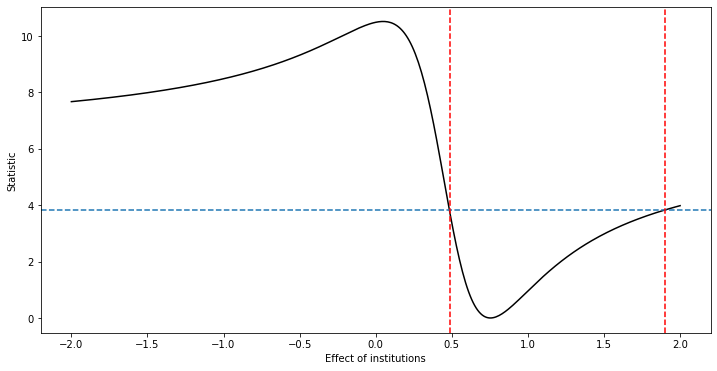

{'UB': 1.9000000000000035, 'LB': 0.490000000000002}

In [23]:
DML_AR_PLIV(rY = DML2_lasso['ytil'], rD= DML2_lasso['dtil'], rZ= DML2_lasso['ztil'],
           grid = np.arange( -2, 2.001, 0.01 ) )

UB = 2.0000000000000036 LB = 0.40000000000000213


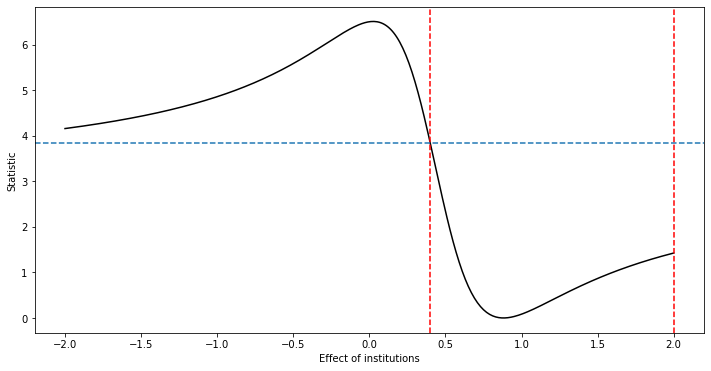

{'UB': 2.0000000000000036, 'LB': 0.40000000000000213}

In [24]:
DML_AR_PLIV(rY = DML2_RF['ytil'], rD= DML2_RF['dtil'], rZ= DML2_RF['ztil'],
           grid = np.arange( -2, 2.001, 0.01 ) )